# Librerias

In [ ]:
import dataAcquisition
import ReparameterizationTrick
import Encoder
import Decoder
import VAE
import loss
import train
import Predictor
import importlib
import numpy as np
#import VAE_mod as VAE
#import train_mod as train#

Datos, Encoder, Decoder y VAE

In [ ]:
import importlib
importlib.reload(dataAcquisition)
importlib.reload(Encoder)
importlib.reload(Decoder)
importlib.reload(VAE)

x_train, x_val, y_train, y_val, average_image, x_train_mix, x_test_mix,x_train_1, y_train_1 =  dataAcquisition.data_acquisition()

encoder = Encoder.encoder(x_train, y_train, latent_dim=2,intermediate_dim=128)
decoder = Decoder.decoder(x_train, y_train,latent_dim=2,intermediate_dim=128)
n_cond = np.shape(y_train)[1]  
vae =  VAE.Vae(encoder,decoder)

x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 28, 28)
x_val.shape:       (5000, 28, 28)
x_test.shape:       (10000, 28, 28)
x_train_mix.shape:  (55000, 28, 28)
x_test_mix.shape:  (10000, 28, 28)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 784)       │          0 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 794)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ encoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    101,760 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,276 (399.52 KB)

 Trainable params: 102,276 (399.52 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_sampling          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 12)        │          0 │ z_sampling[0][0], │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      1,664 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 784)       │    101,136 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,800 (401.56 KB)

 Trainable params: 102,800 (401.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │    102,276 │ input_img[0][0],  │
│ (Functional)        │ (None, 2), (None, │            │ encoder_conditio… │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │    102,800 │ encoder[0][2],    │
│ (Functional)        │                   │            │ decoder_conditio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,076 (801.08 KB)

 Trainable params: 205,076 (801.08 KB)

 Non-trainable params: 0 (0.00 B)

# Compile

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


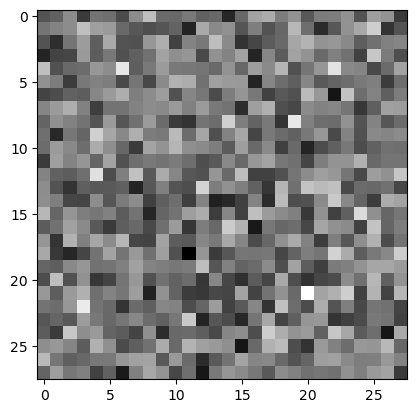

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(loss)
# Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=loss.vae_loss) #cambiar nombre

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

# Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 32.7113 - val_loss: 31.8680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


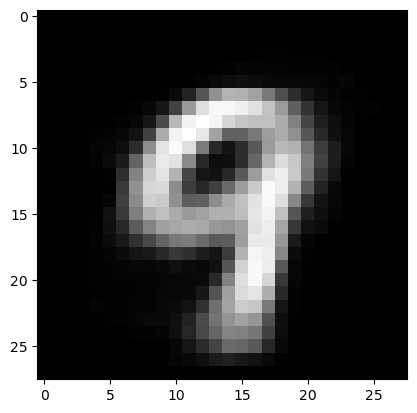

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 32.3754 - val_loss: 31.4928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


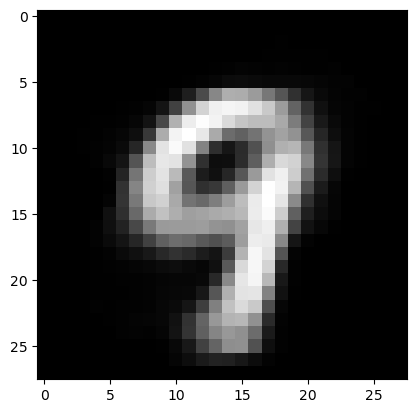

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 32.0451 - val_loss: 31.1943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


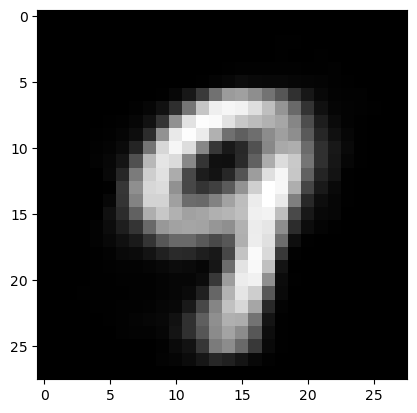

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 31.7497 - val_loss: 30.9280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


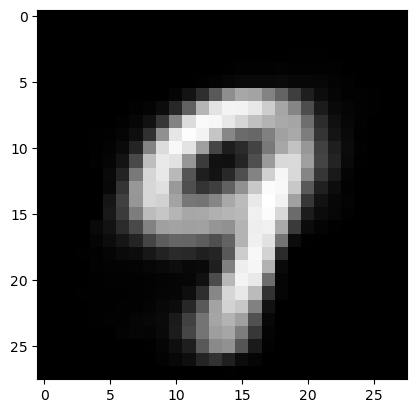

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 31.4324 - val_loss: 30.6924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


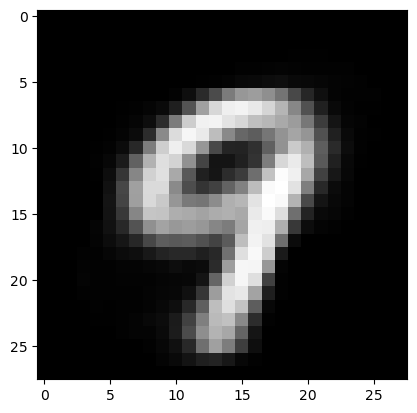

In [31]:
salida = vae.predict([img, cond,cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

for i in range(5):
    train.train(vae, x_train, y_train, x_val, y_val)
    salida = vae.predict([img, cond,cond])
    reconstruccion = salida[0].reshape(28, 28)
    plt.imshow(reconstruccion, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


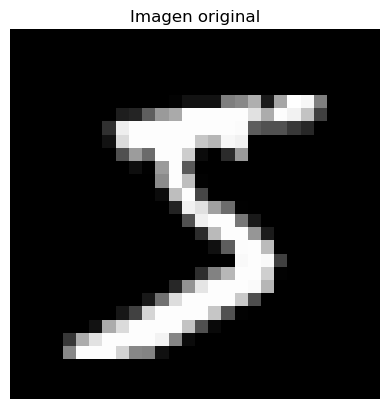

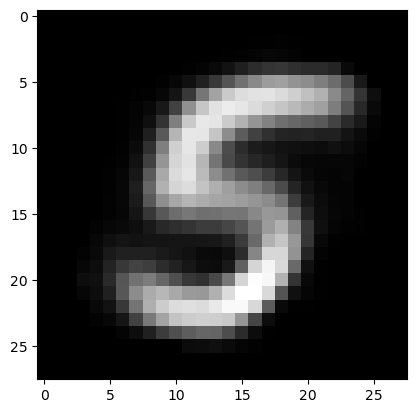

In [32]:
img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond,cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()
plt.imshow(reconstruccion, cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


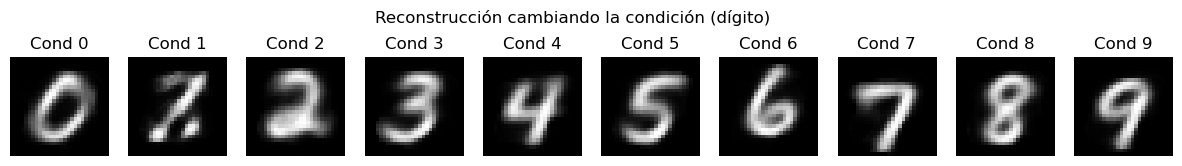

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona una imagen de prueba
img = np.expand_dims(x_train[0], axis=0)

plt.figure(figsize=(15, 2))
for i in range(10):
    # Crea la condición one-hot para el dígito i
    cond = np.zeros((1, 10))
    cond[0, i] = 1

    # Predice usando la misma condición para encoder y decoder
    salida = vae.predict([img, cond, cond])
    reconstruccion = salida[0].reshape(28, 28)

    plt.subplot(1, 10, i + 1)
    plt.imshow(reconstruccion, cmap='gray')
    plt.title(f"Cond {i}")
    plt.axis('off')

plt.suptitle("Reconstrucción cambiando la condición (dígito)")
plt.show()

In [24]:
importlib.reload(Predictor)
predictor_c = Predictor.predictor()

Model: "predictor_C2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ original_input (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer_161               │ (None, 28, 28, 1)      │             0 │
│ (ReshapeLayer)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,378 (196.79 KB)

 Non-trainable params: 192 (768.00 B)

In [25]:
importlib.reload(Predictor)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
predictor_c.compile(optimizer, loss="categorical_crossentropy")
print(img.shape)
prediccion = np.argmax( predictor_c.predict(img))
img[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()


(1, 28, 28)


ValueError: Input 0 of layer "predictor_C2" is incompatible with the layer: expected shape=(None, 784), found shape=(1, 28, 28)

In [ ]:
for i in range(20): 
    #reconstruccion = prediccion[0].reshape(28, 28)
    print(f"prediccion  {prediccion}")
    prediccion = np.argmax(predictor_c.predict(img))


    predictor_c.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=1,
        validation_data=(x_val, y_val)  # Include validation data
        )

prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6850 - val_loss: 0.1023
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1112 - val_loss: 0.0762
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0717 - val_loss: 0.0684
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0571 - val_loss: 0.0639
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0502 - val_loss: 0.0569
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0400 - val_loss: 0.0528
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0338 - val_loss: 0.0557
prediccion  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0287 - v

(55000, 28, 28)
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
tf.Tensor(
[0.6948778  0.49757716 0.54527026 0.4594331  0.715122   0.5922581
 0.25049365 0.6230553  0.3167054  0.54825413], shape=(10,), dtype=float32)
tf.Tensor(
[0.5877456  0.33839253 0.5131177  0.34101164 0.63338995 0.5691512
 0.24298234 0.47640595 0.28917915 0.41837725], shape=(10,), dtype=float32)
tf.Tensor(
[0.6413117  0.41798484 0.529194   0.40022236 0.67425597 0.5807047
 0.24673799 0.5497306  0.30294228 0.4833157 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.33655223 0.3328847  0.4704904  0.52773136 0.38755602 0.6432737
 0.4491788  0.25855002 0.5924869  0.30511683], shape=(10,), dtype=float32)
tf.Tensor(
[0.3513467  0.5009798  0.529388   0.67364573 0.39384297 0.6984303
 0.6098

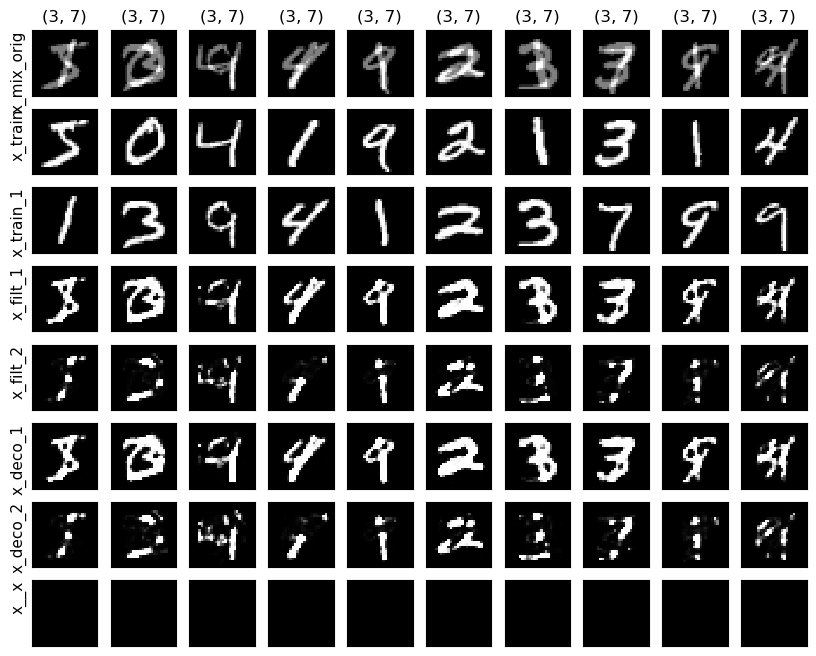

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
tf.Tensor(
[0.76164424 0.5325985  0.5576322  0.42459065 0.81938154 0.58859485
 0.25283933 0.71603817 0.27977332 0.5880698 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.61450964 0.34340444 0.48917598 0.30834517 0.7271566  0.5513028
 0.23402579 0.53573203 0.23545465 0.42182502], shape=(10,), dtype=float32)
tf.Tensor(
[0.688077   0.43800145 0.5234041  0.3664679  0.77326906 0.5699488
 0.24343255 0.6258851  0.257614   0.5049474 ], shape=(10,), 

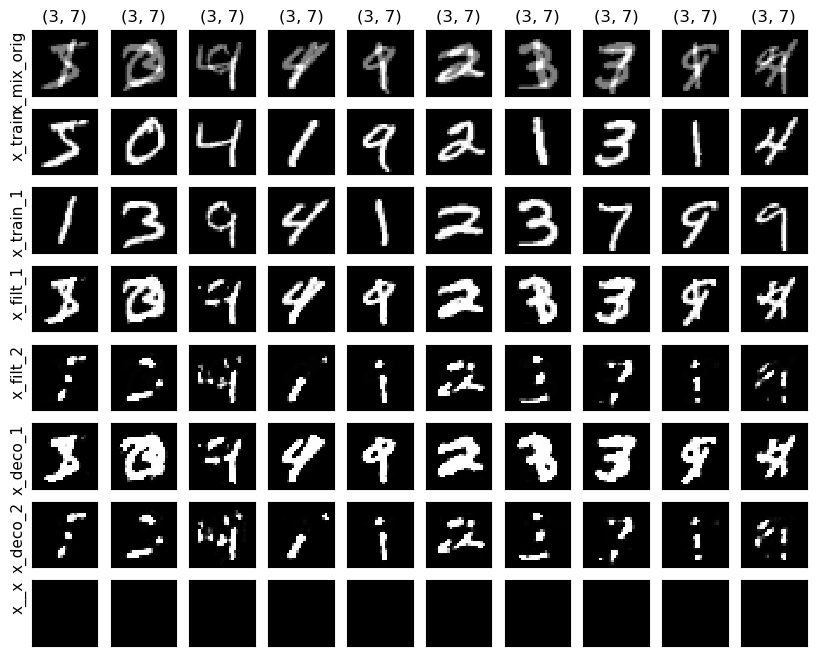

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
tf.Tensor(
[0.7498674  0.5363896  0.5420323  0.4198809  0.82598126 0.5727857
 0.2580573  0.7272202  0.27910542 0.57836246], shape=(10,), dtype=float32)
tf.Tensor(
[0.60682535 0.34631723 0.46596056 0.30522048 0.7293716  0.52864444
 0.23344572 0.5370623  0.23222858 0.43844783], shape=(10,), dtype=float32)
tf.Tensor(
[0.6783464  0.4413534  0.50399643 0.36255068 0.77767646 0.5507151
 0.2457515  0.63214123 0.255667   0.50840515], shape=(10,), 

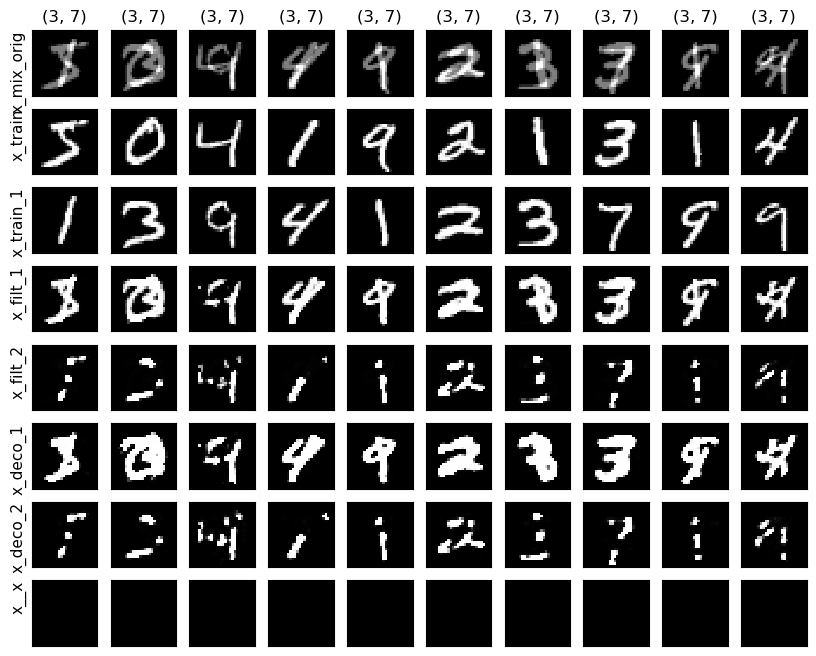

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
tf.Tensor(
[0.7485789  0.5368302  0.52938694 0.41897362 0.8264874  0.56615466
 0.25971344 0.7306337  0.27887538 0.56088495], shape=(10,), dtype=float32)
tf.Tensor(
[0.60210764 0.34793657 0.455173   0.30427715 0.72892886 0.5196054
 0.23191623 0.5352791  0.2313847  0.4267995 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.6753433  0.44238338 0.49227995 0.36162537 0.7777082  0.54288006
 0.24581483 0.6329564  0.25513005 0.49384224], shape=(10,),

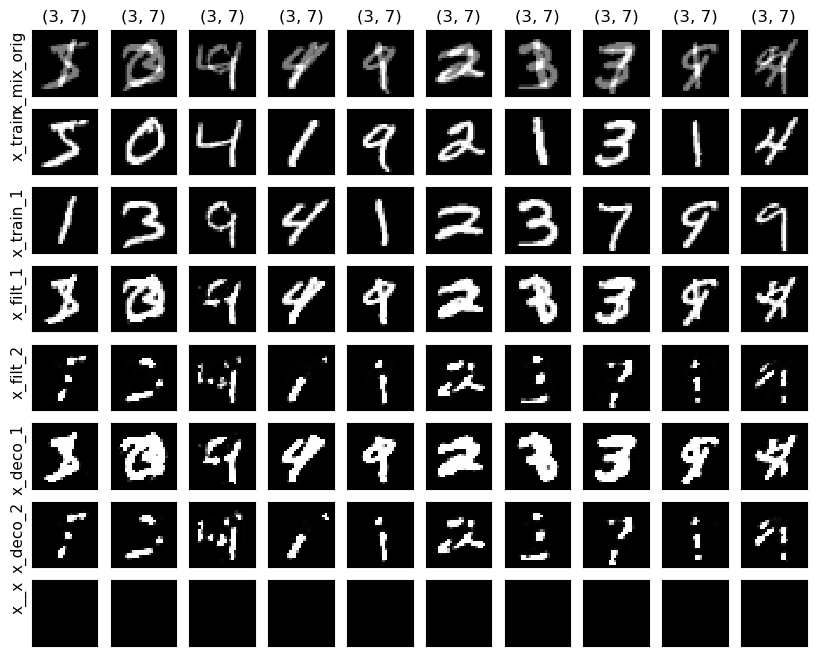

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
tf.Tensor(
[0.7485213  0.5369045  0.5198675  0.41870213 0.8248809  0.5631612
 0.26161307 0.73082864 0.27881786 0.5523544 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.6018691  0.34878936 0.44823447 0.30379388 0.7281082  0.51636004
 0.23109688 0.5358199  0.23132819 0.42570668], shape=(10,), dtype=float32)
tf.Tensor(
[0.6751952  0.44284695 0.484051   0.36124802 0.77649456 0.5397606
 0.24635497 0.63332427 0.255073   0.48903054], shape=(10,), 

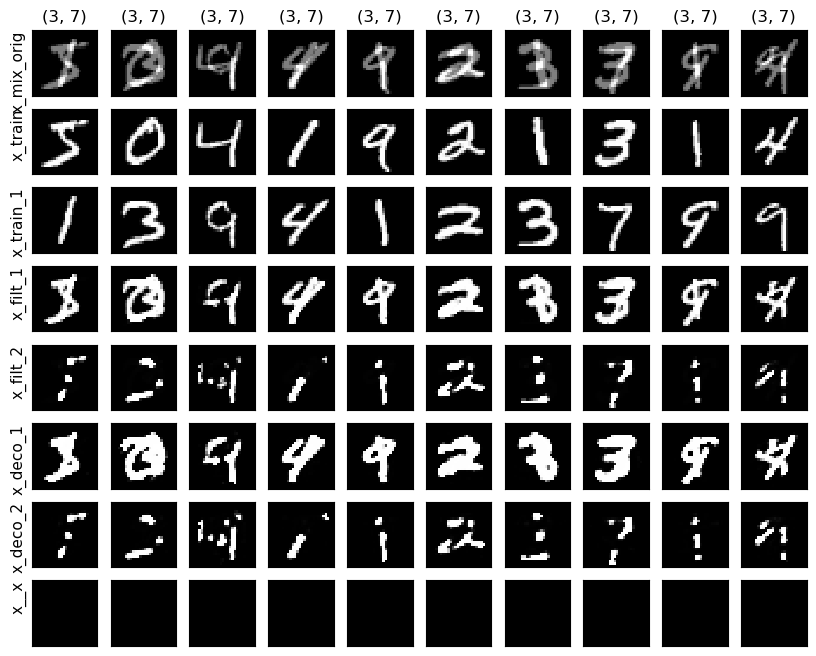

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
tf.Tensor(
[0.74848884 0.5369811  0.51741594 0.41854462 0.8220876  0.5622888
 0.2638635  0.73085296 0.2787595  0.5444065 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.60219675 0.3489393  0.44582158 0.30370286 0.727304   0.5146664
 0.22890867 0.5358091  0.23192897 0.4156651 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.6753428  0.4429602  0.48161876 0.36112374 0.77469575 0.5384776
 0.24638608 0.63333106 0.25534424 0.48003578], shape=(10,), d

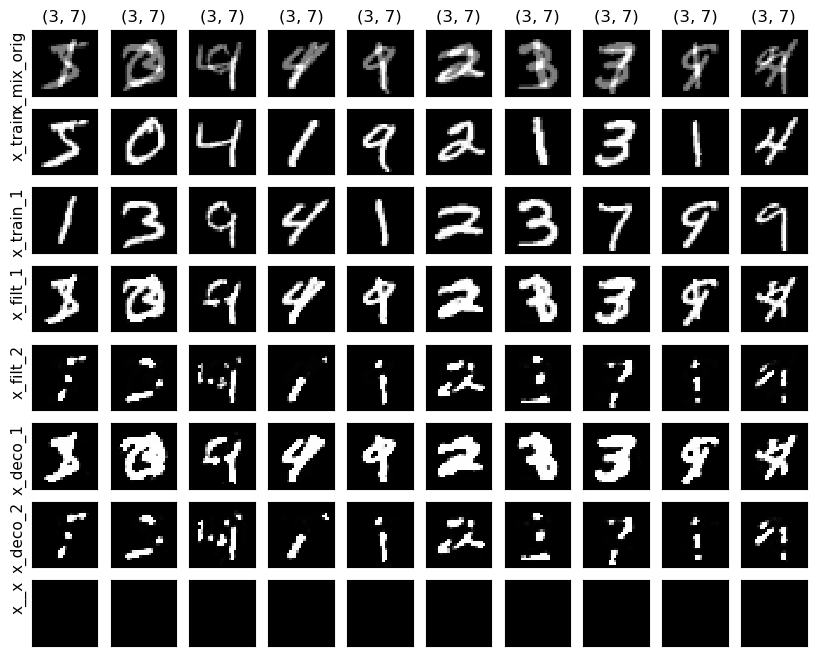

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
tf.Tensor(
[0.7485005  0.5370743  0.5166212  0.4185318  0.82220685 0.56200314
 0.26378754 0.73084104 0.27883524 0.52844113], shape=(10,), dtype=float32)
tf.Tensor(
[0.6019027  0.34854373 0.44519815 0.3039824  0.7270733  0.51364416
 0.229022   0.5356215  0.23111323 0.40782028], shape=(10,), dtype=float32)
tf.Tensor(
[0.67520165 0.44280905 0.48090965 0.3612571  0.7746401  0.5378237
 0.24640477 0.6332313  0.25497425 0.4681307 ], shape=(10,),

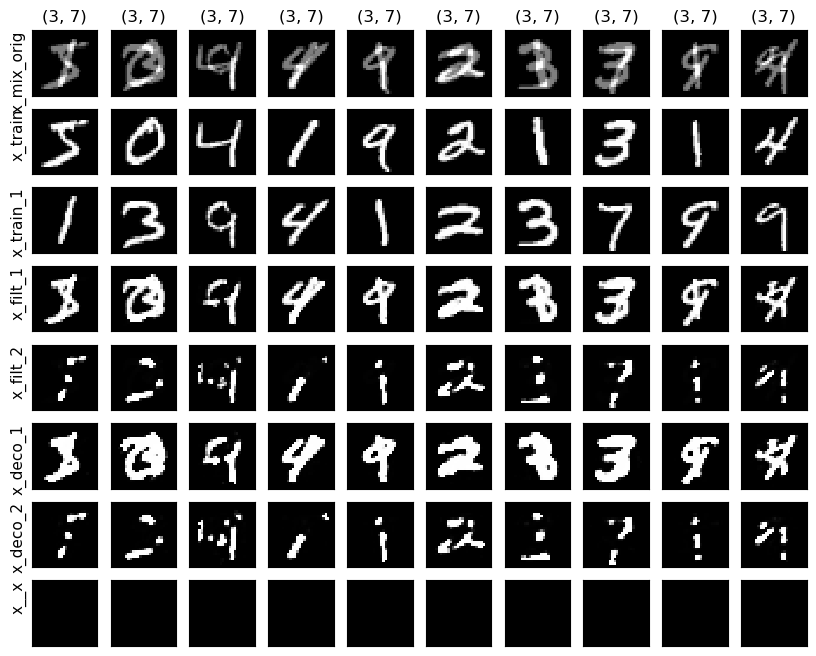

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
tf.Tensor(
[0.74850005 0.53710914 0.5161029  0.41857383 0.82225496 0.56188995
 0.26379457 0.7308556  0.2787271  0.52324665], shape=(10,), dtype=float32)
tf.Tensor(
[0.60201925 0.34898236 0.44497007 0.30390722 0.7273574  0.51318467
 0.22895476 0.5353679  0.2315484  0.40725774], shape=(10,), dtype=float32)
tf.Tensor(
[0.67525965 0.44304574 0.4805365  0.3612405  0.77480614 0.53753734
 0.24637467 0.6331117  0.25513774 0.4652522 ], shape=(10,)

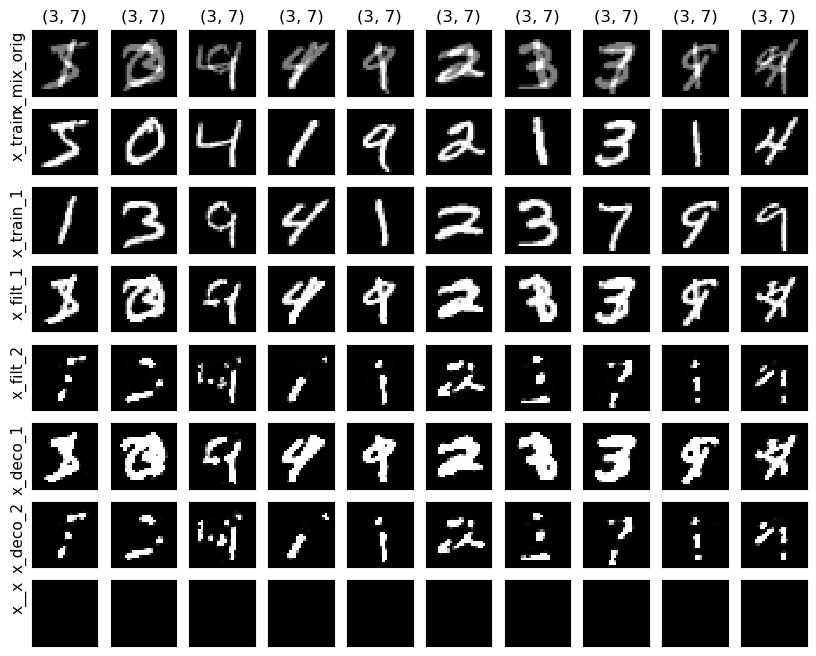

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
tf.Tensor(
[0.74848074 0.5371151  0.51575214 0.41853338 0.8222687  0.5618502
 0.2637921  0.73085445 0.27879894 0.52310485], shape=(10,), dtype=float32)
tf.Tensor(
[0.60172546 0.34857494 0.44490504 0.30383274 0.7271844  0.51280427
 0.2289497  0.535744   0.23180382 0.40695342], shape=(10,), dtype=float32)
tf.Tensor(
[0.67510307 0.44284502 0.4803286  0.36118305 0.77472657 0.53732723
 0.2463709  0.63329923 0.2553014  0.46502912], shape=(10,),

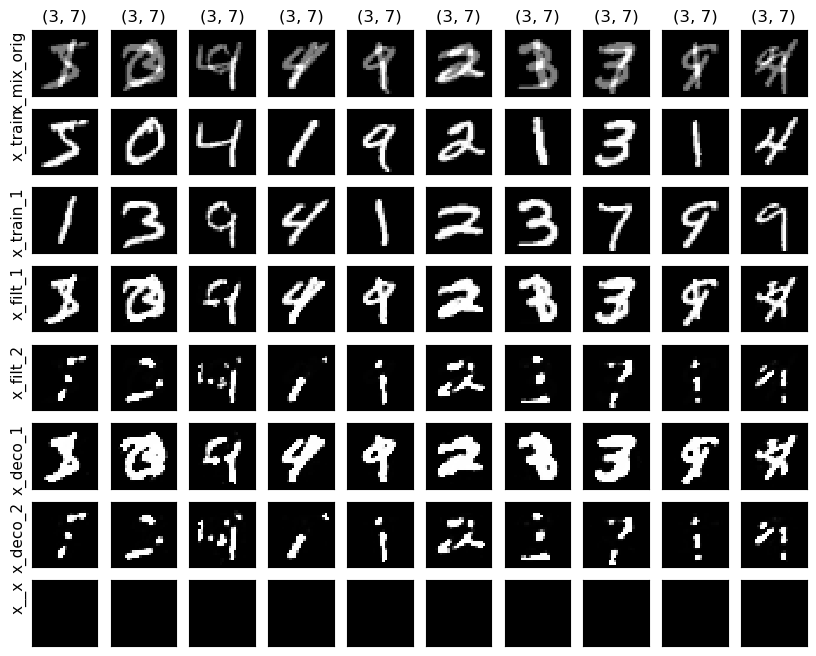

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.
(10, 28, 28)
(10, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
tf.Tensor(
[0.7484875  0.5371274  0.5156346  0.41851613 0.8223086  0.56183654
 0.263786   0.73087037 0.27879655 0.5231367 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.6023612  0.34877974 0.44497237 0.30383244 0.72732466 0.5129845
 0.22906901 0.5359726  0.23131166 0.40696028], shape=(10,), dtype=float32)
tf.Tensor(
[0.67542434 0.44295356 0.48030347 0.3611743  0.77481663 0.5374105
 0.2464275  0.6334215  0.25505412 0.4650485 ], shape=(10,), 

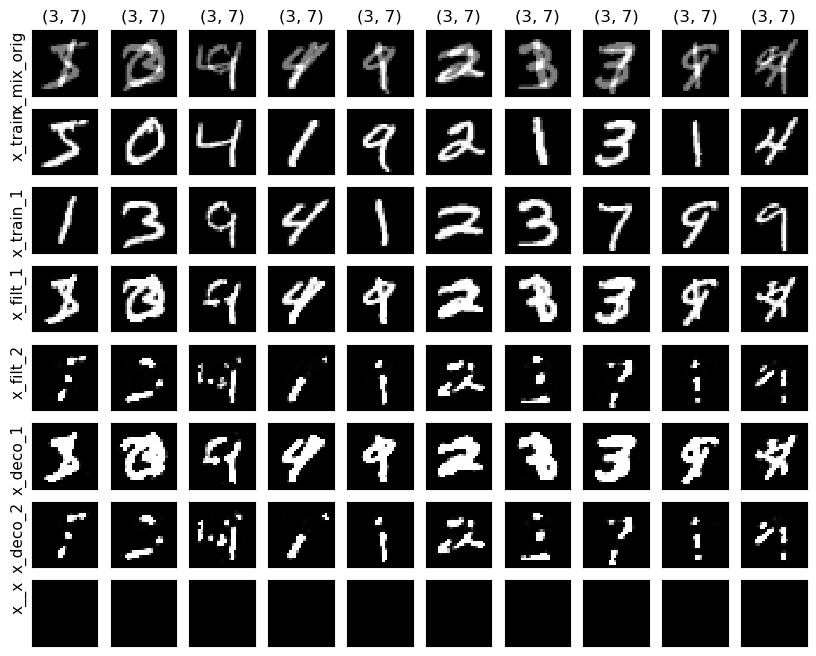

Fig.: En la primera fila se observan las imágenes de TRAIN superpuestas, las componentes en las dos siguientes,
      la reconstrucción final en la cuarta, la mejor imagen original basada en MSE en la quinta y en la última
      la mejor imagen según la predicción.


In [ ]:
import inferencias
importlib.reload(inferencias)
#importlib.reload(outcomes)
print(x_train.shape)
import inferencias
inicio = 0
fin = inicio + 10

# Suponiendo que ya tienes definidos:
# x_train, x_train_1, y_train, y_train_1, predictor, encoder, decoder

inferencias.inferncia_modelo(x_train[inicio:fin], x_train_1[inicio:fin], y_train[inicio:fin], predictor_c, encoder, decoder, y_train_1[inicio:fin],vae)